# Mount Drive and extract rar files of the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/CV Project/source_code'

/content/drive/My Drive/CV Project/source_code


In [3]:
! mkdir '/content/data/wider_face'

mkdir: cannot create directory ‘/content/data/wider_face’: No such file or directory


In [4]:
! mkdir '/content/data/hog_svm'

mkdir: cannot create directory ‘/content/data/hog_svm’: No such file or directory


In [5]:
! unrar x '/content/drive/My Drive/CV Project/source_code/dataset/wider_face.rar'  '/content/data/'

Streaming output truncated to the last 5000 lines.
Extracting  /content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_480.jpg      83%  OK 
Extracting  /content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_49.jpg      83%  OK 
Extracting  /content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_491.jpg      83%  OK 
Extracting  /content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_494.jpg      83%  OK 
Extracting  /content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_498.jpg      83%  OK 
Extracting  /content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_501.jpg      83%  OK 
Extracting  /content/data/wider_face/train/images/55--Sports_Coach_T

In [7]:
! unrar x '/content/drive/My Drive/CV Project/source_code/dataset/hog_svm.rar'  '/content/data/'

Streaming output truncated to the last 5000 lines.
Extracting  /content/data/hog_svm/hard_negatives/80649.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/8065.jpg                 98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80650.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80651.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80652.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80653.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80654.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80655.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80656.jpg                98%  OK 
Extracting  /content/data/hog_svm/hard_negatives/80657.jpg                98%  OK 
Extracting  /content/data/hog

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import joblib
from skimage.transform import pyramid_gaussian
import joblib
from PIL import Image
import os
import random
from tqdm.notebook import tqdm
from PIL import Image


# This function is used to calculate the hog feature descriptor


In [ ]:
import cv2
# hog = cv2.HOGDescriptor()
# test_image = cv2.imread(sample)
cell_size = (6, 6)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# winSize is the size of the image cropped to an multiple of the cell size
# cell_size is the size of the cells of the img patch over which to calculate the histograms
# block_size is the number of cells which fit in the patch

def calculate_hog(img):
  cell_size = (6, 6)  # h x w in pixels
  block_size = (2, 2)  # h x w in cells
  nbins = 9  # number of orientation bins

  img = img.astype(np.uint8)
  # print(img)
  hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                          _blockSize=(block_size[1] * cell_size[1],
                                      block_size[0] * cell_size[0]),
                          _blockStride=(cell_size[1], cell_size[0]),
                          _cellSize=(cell_size[1], cell_size[0]),
                          _nbins=nbins)

  hist = hog.compute(img)
  hist = hist.squeeze()
  return hist

# Obtain positive data

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [ ]:
resized_positive_patches = []
for face in positive_patches:
  new_face = cv2.resize(face, (36,48))
  resized_positive_patches.append(new_face)
positive_patches = np.array(resized_positive_patches)
positive_patches.shape

(13233, 48, 36)

In [ ]:
flipped_positive_patches = []
for face in positive_patches:
  flipped = cv2.flip(face, 1)
  flipped_positive_patches.append(flipped)

flipped_positive_patches = np.array(flipped_positive_patches)
positive_patches = np.concatenate( (positive_patches,flipped_positive_patches), 0 )
positive_patches.shape

(26466, 48, 36)

Text(0.5, 1.0, 'A Face in the dataset')

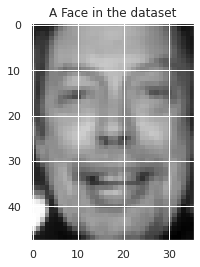

In [ ]:
fig, ax = plt.subplots()
test_face = positive_patches[0]
ax.imshow(test_face, cmap='gray')
ax.set_title('A Face in the dataset')


# cv2_imshow(test_face)

In [ ]:
calculate_hog(test_face).shape

(1260,)

# Obtain negative data

In [ ]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys


In [ ]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 48, 36)

We now have 30,000 suitable image patches which do not contain faces.
Let's take a look at a few of them to get an idea of what they look like:

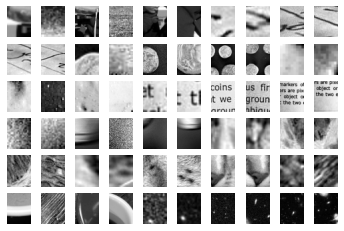

In [ ]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

# Build training data and label

In [ ]:
from itertools import chain
# X_train = np.array([feature.hog(im , orientations = orientations, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block)
#                     for im in chain(positive_patches,
#                                     negative_patches)])

X_train = np.array([calculate_hog(im) for im in chain(positive_patches,negative_patches)])

y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [ ]:
y_train.shape

(56466,)

In [ ]:
X_train.shape

(56466, 1260)

# Train SVC model

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.001,0.01, 0.1, 1]}
svc = LinearSVC()
svc_grid = GridSearchCV(svc, parameters, cv  = 5, verbose = 3)
svc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...........................C=0.001;, score=0.991 total time=   3.3s
[CV 2/5] END ...........................C=0.001;, score=0.975 total time=   1.6s
[CV 3/5] END ...........................C=0.001;, score=0.992 total time=   1.6s
[CV 4/5] END ...........................C=0.001;, score=0.993 total time=   1.9s
[CV 5/5] END ...........................C=0.001;, score=0.994 total time=   1.7s
[CV 1/5] END ............................C=0.01;, score=0.993 total time=   1.5s
[CV 2/5] END ............................C=0.01;, score=0.979 total time=   1.4s
[CV 3/5] END ............................C=0.01;, score=0.995 total time=   1.5s
[CV 4/5] END ............................C=0.01;, score=0.995 total time=   1.6s
[CV 5/5] END ............................C=0.01;, score=0.996 total time=   1.6s
[CV 1/5] END .............................C=0.1;, score=0.991 total time=   1.9s
[CV 2/5] END .............................C=0.1;,

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1]}, verbose=3)

In [ ]:
svc_grid.best_estimator_

LinearSVC(C=0.01)

take the best estimator and re-train it on the full dataset:

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

base_model = svc_grid.best_estimator_
svc_model = CalibratedClassifierCV(base_estimator=base_model, cv= 5)
svc_model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.01), cv=5)

In [ ]:
joblib.dump(svc_model, "./model/svm/svm_baseline.pkl")

['./model/svm/svm_baseline.pkl']

In [ ]:
model = joblib.load("./model/svm/svm_baseline.pkl")

In [ ]:
def sliding_window(img, patch_size= (48,36),
                   istep= 10, jstep = 10, scale=1.0):
    
  Ni, Nj = (int(scale * s) for s in patch_size)
  for i in range(0, img.shape[0] - Ni, istep):
      for j in range(0, img.shape[1] - Ni, jstep):
          patch = img[i:i + Ni, j:j + Nj]
          if scale != 1:
              patch = transform.resize(patch, patch_size)
          yield (i, j), patch

def non_max_suppression(boxes, threshold = 0.5):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > threshold)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")



def detect_faces(model, image, patch_size = (48,36), confidence_threshold = 0.8, overlap_threshold = 0.5):
		# img = color.rgb2gray(image)
	img = image * 255
	positions, patches = zip(*sliding_window(img))
	# patches = np.array(patches)
	# for patch in patches:
	# 	print(patch.shape)
	# 	print(calculate_hog(patch) )
	# 	break
	patches_hog = np.array([calculate_hog(np.array(patch, dtype = np.float32)) for patch in patches])
	# print(patches_hog[1])
	labels = model.predict(patches_hog)
	scores = model.predict_proba(patches_hog)

	positive_indexes = list(np.where(labels == 1)[0])

	positions = np.array(positions)

	boxes = []
	for positive_index in positive_indexes:
		i, j = positions[positive_index]
		confidence = scores[positive_index][1]
		if confidence >= confidence_threshold:
			x_min, y_min = int(j), int(i)
			x_max, y_max = int(j + patch_size[1]), int(i + patch_size[0])
			box = [x_min,y_min,x_max,y_max]
			boxes.append(box)

	boxes = np.array(boxes)
		# final_boxes = non_max_suppression(boxes, threshold = overlap_threshold)
		
		# if visualize:
		# 	for box in final_boxes:
		# 		cv2.rectangle(annotated_img,  (x_min, y_min), (x_max, y_max), (0,0,255), 2)
		# 	return annotated_img
		
	return boxes


# print(detect_faces(model, test_image))
# img = img * 255
# cv2_imshow(img)


In [ ]:
def detect_multiscale(model, image, downscale  = 1.2, patch_size = (48,36), confidence_threshold = 0.9, overlap_threshold = 0.5, visualize = False):
 
  all_boxes = []

  original_width, original_height = img.shape[1], img.shape[0]

  # if len(image.shape) < 3:
  # image = color.rgb2gray(image)

  resize_scale = 900/image.shape[1]
  image = cv2.resize(image, (int(image.shape[1] * resize_scale), int(image.shape[0] * resize_scale)))
  print(image.shape)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  

  for im_scaled in pyramid_gaussian(image, downscale=downscale):
    if im_scaled.shape[0] < (patch_size[0]  * 2) or im_scaled.shape[1] < (patch_size[1] * 2):
        break
    # cv2_imshow(im_scaled * 255)
    boxes = detect_faces(model, im_scaled , patch_size, confidence_threshold , overlap_threshold)
    # print(imsca-)
    for box in boxes:
      x_min, y_min, x_max, y_max = int(box[0]), int(box[1]), int(box[2]), int(box[3])
      x_min = x_min / im_scaled.shape[1] * original_width
      y_min = y_min / im_scaled.shape[0] * original_height
      x_max = x_max / im_scaled.shape[1] * original_width
      y_max = y_max / im_scaled.shape[0] * original_height
      all_boxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
        
  

  all_boxes = np.array(all_boxes)
  all_boxes = non_max_suppression(all_boxes, threshold = overlap_threshold)


  if visualize:
    annotated_img = img.copy()
    for box in all_boxes:
      x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]
      cv2.rectangle(annotated_img,  (x_min, y_min), (x_max, y_max), (0,0,255), 2)
    return annotated_img
  
  return all_boxes



    
# img = detect_multiscale(model, test_image, visualize = True)
# img = img * 255
# cv2_imshow(img)

# detect_multiscale(model, test_image)

(654, 900, 3)


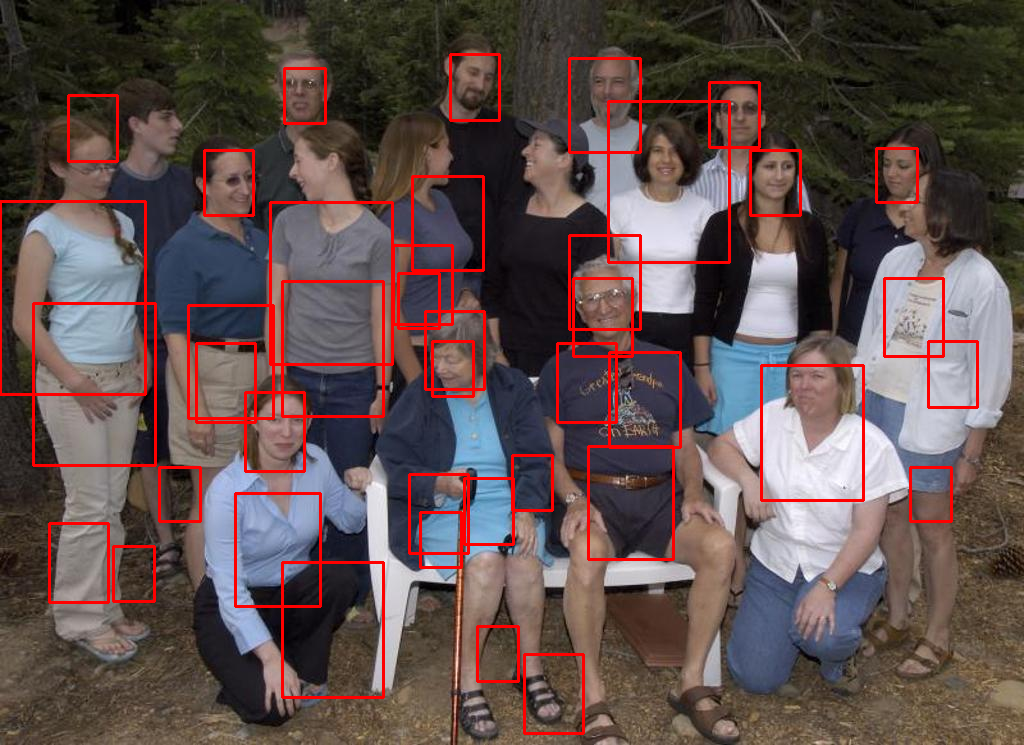

In [ ]:
img_path = '/content/data/wider_face/train/images/6--Funeral/6_Funeral_Funeral_6_383.jpg'
# img_path = '/content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_6.jpg'
# img_path = '/content/data/wider_face/train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_573.jpg'
# img_path = '/content/data/wider_face/train/images/52--Photographers/52_Photographers_photographertakingphoto_52_339.jpg'
# img_path = '/content/data/wider_face/train/images/47--Matador_Bullfighter/47_Matador_Bullfighter_matadorbullfighting_47_770.jpg'
img_path = '/content/data/wider_face/train/images/47--Matador_Bullfighter/47_Matador_Bullfighter_matadorbullfighting_47_644.jpg'
# img_path = '/content/data/wider_face/train/images/12--Group/12_Group_Group_12_Group_Group_12_51.jpg'
img_path = '/content/data/wider_face/train/images/12--Group/12_Group_Large_Group_12_Group_Large_Group_12_731.jpg'
# img_path = '/content/data/wider_face/val/images/13--Interview/13_Interview_Interview_Sequences_13_33.jpg'

img = cv2.imread(img_path)
img = detect_multiscale(model, img, confidence_threshold = 0.9,visualize = True)
img = img 
cv2_imshow(img)




## Hard negative mining

In [ ]:
import json
with open('./dataset/processed/train.json') as f:
  train_data = json.load(f)

train_data

In [ ]:
def calculate_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou


In [ ]:
def check_true_positives(pred_box, gt_boxes):
  true_positive = False
  for gt_box in gt_boxes:
    if calculate_iou(np.array(gt_box), np.array(pred_box)) >= 0.3:
      true_positive = True
      break
  
  return true_positive

In [ ]:
from tqdm.notebook import tqdm
i = 0

# pbar = tqdm(total = 50000)
images = 0
for img_name in tqdm(train_data.keys()):
  img_path = '/content/data/wider_face/train/images/' + img_name
  img = cv2.imread(img_path)
  annotated_img = img.copy()
  gt_boxes =  train_data[img_name]
  predicted_boxes =  detect_multiscale(model, img, confidence_threshold = 0.8, visualize = False)
  for box in predicted_boxes:
    x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]

    cv2.rectangle(annotated_img,  (x_min, y_min), (x_max, y_max), (0,0,255), 2)
    # print(gt_boxes[0])
    # cv2_imshow(img)
    if not check_true_positives(box,gt_boxes):

      x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]
      hard_negative = img[y_min:y_max,x_min:x_max]
      hard_negative =  cv2.cvtColor(hard_negative, cv2.COLOR_BGR2GRAY)
      save_path = './dataset/hog_svm/hard_negatives/' + str(i) + '.jpg'
      cv2.imwrite(save_path, hard_negative)
      i += 1
  




    # if check_true_positives(box,gt_boxes):
    #   x_min, y_min, x_max, y_max = box[0], box[1], box[2], box[3]
    #   face = img[y_min:y_max,x_min:x_max]
    #   cv2_imshow(face)

  # cv2_imshow(img)
  # print(boxes)


  0%|          | 0/10300 [00:00<?, ?it/s]